<a href="https://colab.research.google.com/github/hasdasda/BTLcoLan/blob/main/DeepWeather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

!pip install jupyterplot
from jupyterplot import ProgressPlot
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.3 MB/s eta 0:00:00
  Created wheel for lrcurve: filename=lrcurve-1.1.0-py3-none-any.whl size=69123 sha256=025a9540875c98bd3bd154b3096553d3d5c7c8e2b1105f5146e602dc43ccd5aa
  Stored in directory: /root/.cache/pip/wheels/75/e7/29/57dc532c3d825d8cd28cba5f0c93aafc91b91191879d991b79
Successfully built lrcurve


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1mrIIEKob3yN6i52PaHy2RxJqzfHQfqaF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1mrIIEKob3yN6i52PaHy2RxJqzfHQfqaF" -O DeepWeatherDataset.zip && rm -rf /tmp/cookies.txt

--2025-07-08 12:16:15--  https://docs.google.com/uc?export=download&confirm=&id=1mrIIEKob3yN6i52PaHy2RxJqzfHQfqaF
Resolving docs.google.com (docs.google.com)... 74.125.137.139, 74.125.137.100, 74.125.137.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.137.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1mrIIEKob3yN6i52PaHy2RxJqzfHQfqaF&export=download [following]
--2025-07-08 12:16:15--  https://drive.usercontent.google.com/download?id=1mrIIEKob3yN6i52PaHy2RxJqzfHQfqaF&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.101.132, 2607:f8b0:4023:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.101.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2434 (2.4K) [text/html]
Saving to: ‘DeepWeatherDataset.zip’

DeepWeatherDataset. 100%[===================>]   2.38K  --.-KB/s    

In [39]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1mrIIEKob3yN6i52PaHy2RxJqzfHQfqaF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1mrIIEKob3yN6i52PaHy2RxJqzfHQfqaF" -O DeepWeatherDataset.zip && rm -rf /tmp/cookies.txt
!unzip DeepWeatherDataset.zip
!rm -rf __MACOSX

--2025-07-08 12:16:24--  https://docs.google.com/uc?export=download&confirm=&id=1mrIIEKob3yN6i52PaHy2RxJqzfHQfqaF
Resolving docs.google.com (docs.google.com)... 74.125.137.139, 74.125.137.100, 74.125.137.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.137.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1mrIIEKob3yN6i52PaHy2RxJqzfHQfqaF&export=download [following]
--2025-07-08 12:16:24--  https://drive.usercontent.google.com/download?id=1mrIIEKob3yN6i52PaHy2RxJqzfHQfqaF&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.101.132, 2607:f8b0:4023:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.101.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2434 (2.4K) [text/html]
Saving to: ‘DeepWeatherDataset.zip’

DeepWeatherDataset. 100%[===================>]   2.38K  --.-KB/s    

In [8]:
!mv DeepWeatherDataset/images ./
!mv DeepWeatherDataset/forecast.csv ./
!mv DeepWeatherDataset/observed.csv ./
!rm -rf DeepWeatherDataset

In [ ]:
# !cd /content/drive/MyDrive/Datathoitiet/DeepWeatherDataset/


In [ ]:
# !mv /content/drive/MyDrive/Datathoitiet/DeepWeatherDataset/images ./
# !mv /content/drive/MyDrive/Datathoitiet/DeepWeatherDataset/forecast.csv ./
# !mv /content/drive/MyDrive/Datathoitiet/DeepWeatherDataset/observed.csv ./
# !rm -rf /content/drive/MyDrive/Datathoitiet/DeepWeatherDataset


In [52]:
class DeepWeatherDataset(Dataset):
    def __init__(self, forecasts_file = 'forecast.csv', labels_file = 'observed.csv', img_dir = 'images'):
        self.forecasts = pd.read_csv(forecasts_file)
        self.labels = pd.read_csv(labels_file)
        self.img_dir = img_dir

        self.forecasts_means = self.forecasts.iloc[:, 3:].mean(axis = 0).values
        self.forecasts_std = self.forecasts.iloc[:, 3:].std(axis = 0).values
        self.labels_means = self.labels.iloc[:, 3:].mean(axis = 0).values
        self.labels_std = self.labels.iloc[:, 3:].std(axis = 0).values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        forecast = self.forecasts.iloc[idx, 3:]
        label = self.labels.iloc[idx, 3:]

        forecast = torch.tensor(forecast.values)
        label = torch.tensor(label.values)

        truecolor_img_path = os.path.join(self.img_dir, str(idx) + '_truecolor.jpg')
        evi_img_path = os.path.join(self.img_dir, str(idx) + '_evi.jpg')
        ndmi_img_path = os.path.join(self.img_dir, str(idx) + '_ndmi.jpg')

        truecolor_image = read_image(truecolor_img_path)
        evi_image = read_image(evi_img_path)
        ndmi_image = read_image(ndmi_img_path)

        image = torch.zeros(9, truecolor_image.shape[1], truecolor_image.shape[2])
        image[:3, :, :] = truecolor_image
        image[3:6, :, :] = evi_image
        image[6:9, :, :] = ndmi_image

        image /= 255.0

        forecast = (forecast - self.forecasts_means) / self.forecasts_std
        label = (label - self.labels_means) / self.labels_std


        return [image, forecast], label

In [53]:
dataset = DeepWeatherDataset()

train_len = int(len(dataset) * 0.8)
val_len = len(dataset) - train_len

trainset, valset = torch.utils.data.random_split(dataset, [train_len, val_len])

/tmp/ipython-input-52-1763738962.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  forecast = (forecast - self.forecasts_means) / self.forecasts_std
/tmp/ipython-input-52-1763738962.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  label = (label - self.labels_means) / self.labels_std
/tmp/ipython-input-54-916083294.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  forecast = (forecast * dataset.forecasts_std) + dataset.forecasts_means
/tmp/ipython-input-54-916083294.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  label = (label * dataset.labels_std) + dataset.labels_means


Forecast:
    Average Temp: 301.12K    Min Temp: 300.20K    Max Temp: 302.04K    Humidity: 73.00%    Clouds: 93.00%

Label:
    Average Temp: 301.68K    Min Temp: 300.71K    Max Temp: 302.80K    Humidity: 72.54%



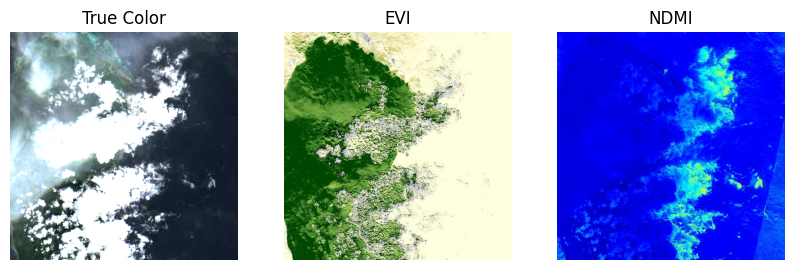

In [54]:
(image, forecast), label = dataset[np.random.randint(low = 0, high = len(dataset))]

forecast = (forecast * dataset.forecasts_std) + dataset.forecasts_means
label = (label * dataset.labels_std) + dataset.labels_means

print(f"Forecast:\n    Average Temp: {forecast[0]:.2f}K    Min Temp: {forecast[1]:.2f}K    Max Temp: {forecast[2]:.2f}K    Humidity: {forecast[4]:.2f}%    Clouds: {forecast[3]:.2f}%")
print(f"\nLabel:\n    Average Temp: {label[0]:.2f}K    Min Temp: {label[1]:.2f}K    Max Temp: {label[2]:.2f}K    Humidity: {label[3]:.2f}%\n")

f = plt.figure(figsize = (10, 10))
plt.subplot(1, 3, 1)
plt.imshow(image[:3].permute(1, 2, 0) * 3)
plt.title('True Color')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image[3:6].permute(1, 2, 0))
plt.title('EVI')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image[6:9].permute(1, 2, 0))
plt.title('NDMI')
plt.axis('off')

plt.show()

In [55]:
class DeepWeather(nn.Module):
    def __init__(self):
        super(DeepWeather, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 9, out_channels = 32, kernel_size = (3, 3), stride = 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p = 0.3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3), stride = 2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3, 3), stride = 2)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(6277, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, inputs):
        x1, x2 = inputs[0], inputs[1]

        x1 = self.bn1(self.dropout(self.pool(F.leaky_relu(self.conv1(x1)))))
        x1 = self.bn2(self.dropout(self.pool(F.leaky_relu(self.conv2(x1)))))
        x1 = self.bn3(self.dropout(self.pool(F.leaky_relu(self.conv3(x1)))))
        x1 = torch.flatten(x1, start_dim = 1)

        x = torch.cat((x1, x2), dim = 1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [56]:
def train(model, trainloader, valloader, criterion, optimizer, epochs, first_time = True, num_saved_epochs = 0):
    if not first_time:
        model = model.load_state_dict(torch.load(f'weights/epoch_{num_saved_epochs}'))

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    pp = ProgressPlot(line_names = ["Training Loss"],
                      x_iterator=False,
                      x_label="Epochs")

    running_loss = 0
    running_valloss = 0
    curr_iter = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        with torch.no_grad():
            for i, data in enumerate(valloader):
                inputs, labels = data[0], data[1]

                inputs[0] = inputs[0].float().to(device)
                inputs[1] = inputs[1].float().to(device)
                labels = labels.float().to(device)

                outputs = model(inputs)

                valloss = criterion(outputs, labels)
                running_valloss += valloss.item()

            avg_valloss = running_valloss / (len(valloader) * (epoch + 1))

        progress_bar = tqdm(enumerate(trainloader), total = len(trainloader))
        for i, data in progress_bar:
            inputs, labels = data[0], data[1]

            inputs[0] = inputs[0].float().to(device)
            inputs[1] = inputs[1].float().to(device)
            labels = labels.float().to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            curr_iter += 1

            progress_bar.set_description(
                f"[{num_saved_epochs + epoch + 1}/{num_saved_epochs + epochs}][{i + 1}/{len(trainloader)}]"
                f"    Training Loss = {(running_loss / curr_iter):.4f}"
                f"    Validation Loss = {avg_valloss:.4f}"
            )

            pp.update(curr_iter / len(trainloader), loss.item())

        train_losses.append((running_loss / curr_iter))
        val_losses.append(avg_valloss)

        torch.save(model.state_dict(), f'weights/epoch_{epoch + 1}')

    return train_losses, val_losses

In [57]:
#Uncomment the lines below if you want to train/load a pretrained model
#num_saved_epochs = 50
#model = model.load_state_dict(torch.load(f'weights/epoch_{num_saved_epochs}'))

#Comment the (ONE) line below if you want to train/load a pretrained model.
!mkdir weights
model = DeepWeather()

trainloader = DataLoader(trainset, batch_size = 2, shuffle = True)
valloader = DataLoader(valset, batch_size = 2, shuffle = True)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.9)

mkdir: cannot create directory ‘weights’: File exists


In [58]:
!rm -rf /content/weights/*


In [59]:
train_losses, val_losses = train(model, trainloader, valloader, criterion, optimizer, epochs = 10, first_time = True, num_saved_epochs = 0)

<IPython.core.display.Javascript object>

/tmp/ipython-input-52-1763738962.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  forecast = (forecast - self.forecasts_means) / self.forecasts_std
/tmp/ipython-input-52-1763738962.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  label = (label - self.labels_means) / self.labels_std
[1/10][873/873]    Training Loss = 0.7373    Validation Loss = 1.0473: 100%|██████████| 873/873 [00:37<00:00, 23.31it/s]
[2/10][873/873]    Training Loss = 0.5933    Validation Loss = 0.7831: 100%|██████████| 873/873 [00:38<00:00, 22.97it/s]
[3/10][873/873]    Training Loss = 0.5114    Validation Loss = 0.6500: 100%|██████████| 873/873 [00:37<00:00, 23.37it/s]
[4/10][873/873]    Training Loss = 0.4597    Validation Loss = 0.5756: 100%|██████████| 873/873 [00:37<00:00, 23.40it/s]
[5/10][873/873]    Training Loss = 0.424

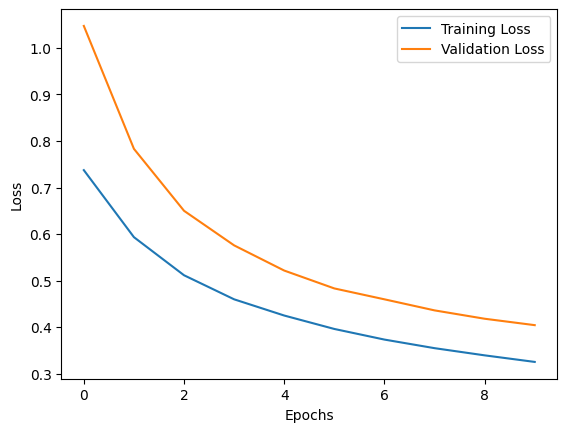

In [60]:
epochs = [epoch for epoch in range(10)]
plt.plot(epochs, train_losses, label = 'Training Loss')
plt.plot(epochs, val_losses, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [61]:
def predict(model, dataset, inputs):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    model = model.to(device)
    inputs[0] = inputs[0].float().to(device)
    inputs[1] = inputs[1].float().to(device)

    outputs = model(inputs)
    outputs = (outputs.cpu().detach().numpy() * dataset.labels_std) + dataset.labels_means

    return outputs

In [62]:
data = valset[np.random.randint(low = 0, high = len(valset))]

inputs = data[0]
inputs[0] = inputs[0].unsqueeze(0)
inputs[1] = inputs[1].unsqueeze(0)

label = (data[1] * dataset.labels_std) + dataset.labels_means
forecast = (inputs[1] * dataset.forecasts_std) + dataset.forecasts_means

prediction = predict(model, dataset, inputs)

forecast = forecast.squeeze()
prediction = prediction.squeeze()

print(f"Forecast:\n    Average Temp: {forecast[0]:.2f}K    Min Temp: {forecast[1]:.2f}K    Max Temp: {forecast[2]:.2f}K    Humidity: {forecast[4]:.2f}%    Clouds: {forecast[3]:.2f}%")
print(f"\nLabel:\n    Average Temp: {label[0]:.2f}K    Min Temp: {label[1]:.2f}K    Max Temp: {label[2]:.2f}K    Humidity: {label[3]:.2f}%")
print(f"\nPrediction:\n    Average Temp: {prediction[0]:.2f}K    Min Temp: {prediction[1]:.2f}K    Max Temp: {prediction[2]:.2f}K    Humidity: {prediction[3]:.2f}%")

Forecast:
    Average Temp: 284.63K    Min Temp: 279.92K    Max Temp: 289.34K    Humidity: 29.00%    Clouds: 0.00%

Label:
    Average Temp: 284.74K    Min Temp: 278.88K    Max Temp: 290.69K    Humidity: 62.58%

Prediction:
    Average Temp: 282.78K    Min Temp: 278.66K    Max Temp: 287.99K    Humidity: 60.85%


/tmp/ipython-input-52-1763738962.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  forecast = (forecast - self.forecasts_means) / self.forecasts_std
/tmp/ipython-input-52-1763738962.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  label = (label - self.labels_means) / self.labels_std
/tmp/ipython-input-62-3227823737.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  label = (data[1] * dataset.labels_std) + dataset.labels_means
/tmp/ipython-input-62-3227823737.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  forecast = (inputs[1] * dataset.forecasts_std) + dataset.forecasts_means


In [63]:
trainloader = DataLoader(trainset, batch_size = 128, shuffle = False)
train_r2 = 0
train_avg_temp_r2 = 0
train_min_temp_r2 = 0
train_max_temp_r2 = 0
train_humidity_r2 = 0
for i, data in enumerate(trainloader):
    inputs = data[0]
    labels = data[1]
    labels = (labels * dataset.labels_std) + dataset.labels_means

    outputs = predict(model, dataset, inputs)

    train_r2 += r2_score(labels, outputs)
    train_avg_temp_r2 += r2_score(labels[:, 0], outputs[:, 0])
    train_min_temp_r2 += r2_score(labels[:, 1], outputs[:, 1])
    train_max_temp_r2 += r2_score(labels[:, 2], outputs[:, 2])
    train_humidity_r2 += r2_score(labels[:, 3], outputs[:, 3])

train_r2 /= len(trainloader)
train_avg_temp_r2 /= len(trainloader)
train_min_temp_r2 /= len(trainloader)
train_max_temp_r2 /= len(trainloader)
train_humidity_r2 /= len(trainloader)

print("Training Data R2 Scores:")
print(f"    Avg Temp: {train_avg_temp_r2:.3f}")
print(f"    Min Temp: {train_min_temp_r2:.3f}")
print(f"    Max Temp: {train_max_temp_r2:.3f}")
print(f"    Humidity: {train_humidity_r2:.3f}")
print(f"    Total: {train_r2:.3f}")




valloader = DataLoader(valset, batch_size = 128, shuffle = False)
val_r2 = 0
val_avg_temp_r2 = 0
val_min_temp_r2 = 0
val_max_temp_r2 = 0
val_humidity_r2 = 0
for i, data in enumerate(valloader):
    inputs = data[0]
    labels = data[1]
    labels = (labels * dataset.labels_std) + dataset.labels_means

    outputs = predict(model, dataset, inputs)

    val_r2 += r2_score(labels, outputs)
    val_avg_temp_r2 += r2_score(labels[:, 0], outputs[:, 0])
    val_min_temp_r2 += r2_score(labels[:, 1], outputs[:, 1])
    val_max_temp_r2 += r2_score(labels[:, 2], outputs[:, 2])
    val_humidity_r2 += r2_score(labels[:, 3], outputs[:, 3])

val_r2 /= len(valloader)
val_avg_temp_r2 /= len(valloader)
val_min_temp_r2 /= len(valloader)
val_max_temp_r2 /= len(valloader)
val_humidity_r2 /= len(valloader)

print("\nValidation Data R2 Scores:")
print(f"    Avg Temp: {val_avg_temp_r2:.3f}")
print(f"    Min Temp: {val_min_temp_r2:.3f}")
print(f"    Max Temp: {val_max_temp_r2:.3f}")
print(f"    Humidity: {val_humidity_r2:.3f}")
print(f"    Total: {val_r2:.3f}")




dataloader = DataLoader(dataset, batch_size = 128)
forecast_r2 = 0
forecast_avg_temp_r2 = 0
forecast_min_temp_r2 = 0
forecast_max_temp_r2 = 0
forecast_humidity_r2 = 0
for i, data in enumerate(dataloader):
    inputs = data[0]
    labels = data[1]
    forecasts = inputs[1]
    forecasts = forecasts[:, np.r_[:3, 4]]

    forecast_avg_temp_r2 += r2_score(labels[:, 0], forecasts[:, 0])
    forecast_min_temp_r2 += r2_score(labels[:, 1], forecasts[:, 1])
    forecast_max_temp_r2 += r2_score(labels[:, 2], forecasts[:, 2])
    forecast_humidity_r2 += r2_score(labels[:, 3], forecasts[:, 3])
    forecast_r2 += r2_score(forecasts, labels)

forecast_r2 /= len(dataloader)
forecast_avg_temp_r2 /= len(dataloader)
forecast_min_temp_r2 /= len(dataloader)
forecast_max_temp_r2 /= len(dataloader)
forecast_humidity_r2 /= len(dataloader)

print("\nForecast Data R2 Scores:")
print(f"    Avg Temp: {forecast_avg_temp_r2:.3f}")
print(f"    Min Temp: {forecast_min_temp_r2:.3f}")
print(f"    Max Temp: {forecast_max_temp_r2:.3f}")
print(f"    Humidity: {forecast_humidity_r2:.3f}")
print(f"    Total: {forecast_r2:.3f}")

/tmp/ipython-input-52-1763738962.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  forecast = (forecast - self.forecasts_means) / self.forecasts_std
/tmp/ipython-input-52-1763738962.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  label = (label - self.labels_means) / self.labels_std
/tmp/ipython-input-63-72249821.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  labels = (labels * dataset.labels_std) + dataset.labels_means
/tmp/ipython-input-52-1763738962.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  forecast = (forecast - self.forecasts_means) / self.forecasts_std
/tmp/ipython-input-52-1763738962.py:38: De

Training Data R2 Scores:
    Avg Temp: 0.903
    Min Temp: 0.874
    Max Temp: 0.897
    Humidity: 0.442
    Total: 0.779


/tmp/ipython-input-52-1763738962.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  forecast = (forecast - self.forecasts_means) / self.forecasts_std
/tmp/ipython-input-52-1763738962.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  label = (label - self.labels_means) / self.labels_std
/tmp/ipython-input-63-72249821.py:45: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  labels = (labels * dataset.labels_std) + dataset.labels_means
/tmp/ipython-input-52-1763738962.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  forecast = (forecast - self.forecasts_means) / self.forecasts_std
/tmp/ipython-input-52-1763738962.py:38: De


Validation Data R2 Scores:
    Avg Temp: 0.865
    Min Temp: 0.829
    Max Temp: 0.858
    Humidity: 0.337
    Total: 0.722


/tmp/ipython-input-52-1763738962.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  forecast = (forecast - self.forecasts_means) / self.forecasts_std
/tmp/ipython-input-52-1763738962.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  label = (label - self.labels_means) / self.labels_std
/tmp/ipython-input-52-1763738962.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  forecast = (forecast - self.forecasts_means) / self.forecasts_std
/tmp/ipython-input-52-1763738962.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  label = (label - self.labels_means) / self.labels_std
/tmp/ipython-input-52-1763738962.py:37: Deprecat


Forecast Data R2 Scores:
    Avg Temp: 0.672
    Min Temp: 0.517
    Max Temp: 0.791
    Humidity: 0.055
    Total: 0.660


/tmp/ipython-input-52-1763738962.py:37: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  forecast = (forecast - self.forecasts_means) / self.forecasts_std
/tmp/ipython-input-52-1763738962.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  label = (label - self.labels_means) / self.labels_std


In [64]:
!zip -r weights.zip /content/weights
from google.colab import files
files.download('weights.zip')

  adding: content/weights/ (stored 0%)
  adding: content/weights/epoch_9 (deflated 7%)
  adding: content/weights/epoch_6 (deflated 7%)
  adding: content/weights/epoch_5 (deflated 7%)
  adding: content/weights/epoch_7 (deflated 7%)
  adding: content/weights/epoch_2 (deflated 8%)
  adding: content/weights/epoch_4 (deflated 8%)
  adding: content/weights/epoch_3 (deflated 8%)
  adding: content/weights/epoch_1 (deflated 8%)
  adding: content/weights/.ipynb_checkpoints/ (stored 0%)
  adding: content/weights/epoch_10 (deflated 7%)
  adding: content/weights/epoch_8 (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>